In [1]:
# Import needed packages
# These are copied directly from Notebook-2-Regularization (Butler)

import dolfin as fn
import numpy as np
import scipy as sp
from scipy import integrate

from matplotlib import pyplot as plt
%matplotlib notebook
#matplotlib inline

from IPython.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Group Homework 1

## Jordan Hall and Daniel Bielich

## Math 8660

## Problem 1

This problem develops the smooth functions that can be used to define a partition of unity whose existence is discussed but not proven in Hunter's notes (see his Theorem 1.31 and the paragraph that follows).


Partitions of unity prove quite useful in proving a lot of results about Sobolev spaces (read the first part of Section 3.11) and regularity of solutions to PDEs (see, e.g., the first paragraph of Section 4.12). There are many incorrect and/or incomplete proofs of these results on the inter-webs (a confounding number actually). The basis functions we commonly use in a FEM are like a less smooth version of a partition of unity.

### Problem 1. (a.)

Let $U, V$ be non-empty open sets in $\mathbb{R}^n$ with $V\Subset U$. Show there exists a smooth (i.e., $C^\infty$) function $\psi$ such that $\psi\equiv 1$ on $V$ and $\psi = 0$ near $\partial U$ (i.e., supp$ (\psi) \Subset U$). 		
				
Here is a collection of facts, results, and hints which may prove useful:

1. For any bounded set $A\subset\mathbb{R}^n$, $J_\epsilon * \chi_A$ defines a smooth function with support $A + B_\epsilon(0) = \left\{x\in\mathbb{R}^n \, : \, d(x,A)<\epsilon)\right\}$. 
				
2. Recall that $V\Subset U$ implies that $\overline{V}\subset U$, $\overline{V}$ is compact, and 
				
$$\text{dist}(V,\partial U) = \inf\{||x-y||_{\mathbb{R}^n}\, : \, x\in V, y\in\partial U\} > 0.$$

3. There exists non-empty open set $W$ such that $V\Subset W\Subset U$ (why? hint: $W$ can be written as a finite union of open balls). 
				
4. Argue the existence of an $\epsilon>0$ such that if we mollify $\chi_W$ with $J_\epsilon$ this is the desired function $\psi$. (Hint: draw a picture of $V\Subset W\Subset U$ to determine how $\epsilon$ must be chosen.)
			

### Solution 1. (a.)

Let $V \Subset U$ and $\epsilon := \frac{\text{dist}(V,\partial U)}{2}$. Because $V \Subset U \subset \mathbb{R}^n$ there exists a collection of points $\{v_i \in \; V \}_{i=1}^N : V \subset \cup_{i=1}^N B_{\epsilon}(v_i) =: W \subset U$. Thus $W$ is defined as a collection of open balls so it's clear its closure is compact and by construction is compactly contained in $U$. Hence $V \Subset  W  \Subset U$. Using the standard mollifier to the characteristic function on $W$, $J_{\epsilon} * \chi_W$ takes $\chi_W$ and defines a smooth function with support $S := \text{supp} ( J_{\epsilon} * \chi_W) = W + B_{\epsilon} (0) = \{ x \in \mathbb{R}^n | d(x,W)<\epsilon \}$.  

### Problem 1. (b.)

Use FEniCS to plot such a function from part (a) on the unit square domain. 

### Solution 1. (b.)

We plot the mollified function below.

In [2]:
# Create a mesh to evaluate our function over
grid_x = 20
grid_y = 20 # Make the mesh finer by increasing these values
             # and the resulting plot will look smoother

mesh = fn.RectangleMesh(fn.Point(0, 0), fn.Point(1, 1), grid_x, grid_y, 'right')
V1 = fn.FunctionSpace(mesh, "Lagrange", 1)

#fig = plt.figure(figsize=(8,4))
#fn.plot(mesh)
#plt.tight_layout()
#plt.show()

In [3]:
# A function, "UnitBox" which is 1 everywhere on the unit square

class UnitBox(fn.UserExpression):
    def __init__(self, a, b, **kwargs):
        self.a = a
        self.b = b
        super().__init__(**kwargs)
    def eval(self, v, x):
        v[0] = 0
        if (x[0] >= self.a) & (x[1] >= self.b):
            v[0] = 1
        return v
    def value_shape(self):
        return ()

In [4]:
# Interpolate our function
my_interpolant = fn.interpolate( UnitBox(a=0, b=0, degree=1), V1)

# And plot it!
#fig = plt.figure()
#my_plot = fn.plot(my_interpolant)
#my_plot.set_cmap("jet")
#plt.colorbar(my_plot,fraction=0.1, pad=0.1)

In [5]:
class Mollifier(fn.UserExpression):
    def __init__(self, x_pt, eps, C, **kwargs):
        self.x0 = x_pt[0]
        self.x1 = x_pt[1]
        self.eps = eps
        self.C = C
        super().__init__(**kwargs)
    def eval(self, v, x):
        v[0] = 0
        a = ( (x[0]-self.x0)**2+(x[1]-self.x1)**2 ) / eps**2
        if (a < 1):
            v[0] = (1/self.C) * fn.exp( 1 / (a-1) ) / eps**2
        return v
    def value_shape(self):
        return ()

In [6]:
eps = 0.1 #The smoothing factor

C = fn.assemble( fn.interpolate(Mollifier([0.5, 0.5], eps, 1, degree=1), V1)*fn.dx ) #The normalizing constant


mollifier = fn.interpolate(Mollifier([0.5, 0.5], eps, C, degree=1), V1) #The actual mollifier

print(fn.assemble(mollifier*fn.dx)) #Check that the mollifier is properly normalized

#plot the mollifier
#fig = plt.figure()
#mol_plot = fn.plot(mollifier)
#mol_plot.set_cmap("jet")
#plt.colorbar(mol_plot,fraction=0.046, pad=0.04)

0.9999999999999997


In [7]:
# Extract grid from mesh objects (first and second columns of coors and coors_compact) as numpy arrays.

coors = mesh.coordinates()

#if grid_x*grid_y < 101:
    #print(coors) 

In [8]:
u_disc_smooth_vals = np.zeros((grid_x+1)*(grid_y+1))

for i in range(coors[:,0].size):
    u_disc_smooth_vals[i] = fn.assemble(Mollifier([coors[i,0], coors[i,1]], eps, C) * my_interpolant * fn.dx)

In [9]:
# For plotting in matplotlib

mesh_X = coors[:,0].reshape((grid_x+1,grid_y+1))
mesh_Y = coors[:,1].reshape((grid_x+1,grid_y+1))

u_disc_smooth_vals = u_disc_smooth_vals.reshape((grid_x+1,grid_y+1))
u_disc_exact_vals = my_interpolant.compute_vertex_values(mesh).reshape((grid_x+1,grid_y+1))

Flushing output cache (0 entries)


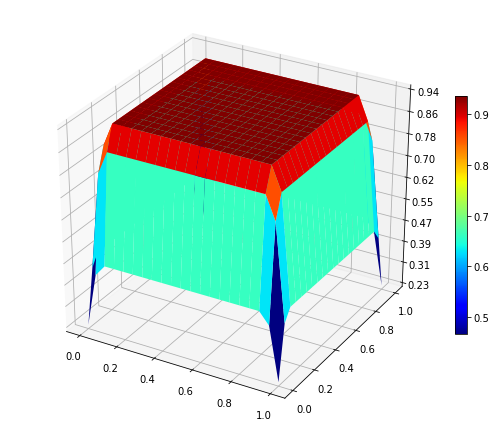

In [10]:
%reset -f out

fig = plt.figure(figsize=(7,18))
ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

### Problem 1. (c.) 

Assume $\Omega\subset\mathbb{R}^n$ is a non-empty bounded open set so $\overline{\Omega}$ is compact and let $\{B_i\, : \, 1\leq i\leq N\}$ be an open cover of $\overline{\Omega}$. A partition of unity $\{\psi_i \, : \, 1\leq i \leq N\}$ subordinate to the cover has the property that $\psi_i\in C^\infty_c(B_i)$ for $1\leq i\leq N$, $0\leq \psi\leq 1$, and $\sum_{i=1}^N \psi_i = 1$ on $\overline{\Omega}$. Prove that a partition of unity exists. 
	
Here is a collection of facts, results, and hints which may prove useful.
		
1. There exists compact sets $K_i\subset B_i$ for $1\leq i\leq N$ such that $\overline{\Omega}\subset \cup_{i=1}^N K_i$ (why?). 

2. By part (a), for $1\leq i\leq N$ there exists $g_i\in C^\infty_c(B_i)$ such that $g_i(x)>0$ on $K_i$.

3. By part (a), there exists a smooth function $f(x)$ that is equal to $1$ on $\overline{\Omega}$ and supp$(f)\Subset \cup_{i=1}^N$ supp$(g_i)$.

4. If we let $g_{N+1}(x)=1-f(x)$, then for $1\leq i \leq N$, the functions $\psi_i(x) = g_i/\sum_{k=1}^{N+1} g_k$ are the functions we want (why? also, do not forget to check that we never divide by zero).
	

### Solution 1. (c.)

Because $\Omega \subset \mathbb{R}^n$ is bounded, there exists $\epsilon > 0$ such that $B_i := B_{\epsilon}(\omega_i)$ and $\cup_{i=1}^N B_i =: B \supset \overline{\Omega}$ for $\{ \omega_i \in \Omega\}_{i=1}^N$. Let $\delta := $ dist$(\overline{\Omega},\partial B) > 0$. Then define $\nu = \epsilon - \frac{\delta}{2}>0$. It follows by defining $K_i := \overline{B_{\nu}(\omega_i)}$ that $B \supset \cup_{i=1}^N \overline{B_{\nu}(\omega_i)} =: K \supset \overline{\Omega}$. 
 
On each $K_i$ take any function -- call it $g_i(x)$ -- such that $g_i > 0$ on $K_i$ and 0 otherwise. Also, define $f(x) = J_{\nu} * \chi_{\overline{\Omega}}(x)$. Then $ \text{supp}(f) \Subset \cup_{i=1}^N\text{supp}(g_i)=K$ and by part (a) $f \equiv 1$ on $\overline{\Omega}$ and is 0 otherwise.

Define $\psi_i = \frac{g_i}{\sum_{k=1}^{N+1}g_k}$ and note $1-f(x) = 0$ for $x\in\overline{\Omega}$. Outside $\overline{\Omega}, f(x) = 0$ thus $1-f(x) = 1$ which prevents us from ever dividing by zero in our formulation of the $\psi_i$'s. Finally we have

\begin{equation*}
    \sum_{i=1}^{N}\psi_i = \frac{\sum_{i=1}^{N} g_i}{\sum_{k=1}^{N+1} g_k} = \frac{g_1 + \dots + g_N}{g_1 + \dots + g_N + 1 - f(x)} = \frac{g_1 + \dots + g_N}{g_1 + \dots + g_N} = 1 \;\;\text{ on }\;\; \overline{\Omega}
\end{equation*}

Because $g_i \equiv 0$ and $f \equiv 0$ outside $\overline{\Omega}$, the above ratio reduces to 

\begin{equation*}
    \sum_{i=1}^{N}\psi_i = \frac{0}{1}=0 \;\;\text{ outside }\;\; \overline{\Omega},
\end{equation*}

as desired.

## Problem 2

Here we describe some of the continuity properties of functions in a Sobolev space on a simple domain $\Omega = (0,1)\subset\mathbb{R}$ as well as provide a computational bound on how much the function values may change as the inputs are perturbed. Absolute continuity is like a strengthened form of uniform continuity. You may recall that Lipschitz continuity is stronger than uniform continuity (i.e., all Lipschitz continuous functions are uniformly continuous). Lipschitz continuity is in fact even stronger than absolute continuity (see Example 3.57 in Hunter's notes). It probably comes as no surprise that if we ever have a choice, we would almost always choose to work with a Lipschitz continuous function. You may find reading over Section 3.A.2 in Hunter's notes to be useful (and short at just under 2 pages in length). The basic take away from absolute continuity is that this provides the necessary and sufficient condition for the fundamental theorem of calculus to hold using the Lebesgue notion of integration. Consequently, a function is absolutely continuous if and only if its weak derivative is integrable. 

### Problem 2. (a.)

Prove that if $u\in W^{1,p}(\Omega)$ for some $1\leq p < \infty$ that $u$ is equal a.e.~to an absolutely continuous function, and $u'$ (which exists a.e.) belongs to $L^p(\Omega)$.
		

1. Since $u\in W^{1,p}(\Omega)$ immediately implies that there exists weak derivative $u'\in L^p(\Omega)$, the goal here is to prove that $u'\in L^1(\Omega)$ and use Theorem 3.63 in Hunter.

2. As a first step to use Theorem 3.63 in Hunter, use Corollary 1 from my lecture 0 notes to get that $u\in L^1_{loc}(\Omega)$. 

3. H\"older's inequality states that if $p,q\in[1,\infty]$ with $1/p + 1/q = 1$ (using the convention that $1/\infty=0$), then $||fg||_{L^1}\leq ||f||_{L^p}||g||_{L^q}$. 

4. To show that $u'\in L^1(\Omega)$, use H\"older's inequality to bound $||u'||_{L^1}$ in terms of $||u'||_{L^p}$ and another function. (Hint: $u'$ is always equal to $u'$ times another function. Observe here that bounding the $L^1$-norm of $u'$ fundamentally relies upon the fact that $\Omega=(0,1)$ is a bounded subset of $\mathbb{R}$.)
	

### Solution 2. (a.)

Let $u \in W^{1,p}(\Omega)$. Then the weak derivative $u^{\prime}$ exists and is in $L^p(\Omega)$. In addition from Corollary 1 in the Lecture 0 notes it follows $u \in L^1_{loc}(\Omega)$. Theorem 3.63 from Hunter states any function $u\in L_{loc}^1(\Omega)$ is absolutely continuous if and only if $u$ is weakly differentiable in $\Omega$ and $u^{\prime} \in L^1(\Omega)$.  Thus to show $u$ is absolutely continuous on $\Omega$ we only need to show the weak derivative of $u$, denoted by $u'$, is $L^1$ integrable. Choose $q\in \mathbb{N}$ so that $\frac{1}{p} + \frac{1}{q} = 1$. Applying Holders inequality it follows

$$
||u^{\prime}||_{L_1} = ||u^{\prime}\cdot 1||_{L_1} \leq ||u^{\prime}||_{L_p}||1||_{L_q} = ||u^{\prime}||_{L_p} < \infty
$$

Where the last equality follows from $\Omega = (0,1)$. So $ ||1||_{L_q} = \left(\int_0^1 |1|^q\right)^{\frac{1}{q}} = 1$. Thus the weak derivative of $u$ is $L_1$ integrable and hence $u$ is absolutely continuous.

### Problem 2. (b.) 

Prove directly that if $u\in W^{1,p}(\Omega)$ for some $1<p<\infty$, then 
		
$$|u(x)-u(y)| \leq |x-y|^{1-\frac{1}{p}}||u'||_{L^p} \ \text{ for a.e. } x,y\in \overline{\Omega} = [0,1].$$
		
		
1. By part (a), for all such $p$, $u$ is absolutely continuous and the fundamental theorem of calculus holds, i.e., we can use Theorem 3.60 in Hunter's notes to get for any $x,y\in[a,b]$ that
			
$$|u(x)-u(y)| = \left| \int_y^x u'(t) dt\right|.$$

2. Now use Holder's inequality and the fact that if $A\subset B$, then $||u'||_{L^p(A)} \leq ||u'||_{L^p(B)}$.
		
	

### Solution 2. (b.)

As above, by part (a) for all such $p,u$ we have that $u$ is absolutely continuous. Theorem 3.60 in Hunter discusses an if and only if statement regarding absolute convergence. The main subpart that follows from Theorem 3.60 is if a function $u\in L_1$ and $u$ is absolutely continuous, this implies $\forall \; x \in \overline{\Omega} = [0,1]$ we have $u(x) = u(0) + \int_0^xu^{\prime}(t)dt$. Thus for any $x,y \in [0,1]$, without loss of generality assume $y<x$, we have

$$
\begin{cases} 
      u(x) = u(0) + \int_0^x u^{\prime}(t)dt \\
      u(y) = u(0) + \int_0^y u^{\prime}(t)dt
\end{cases}
$$

$$
\implies \quad u(x) - u(y) = \int_y^x u^{\prime}(t)dt = ||u^{\prime}||_{L_1[y,x]}
$$

Applying Holders inequality to the right-hand side for the some $q\in\mathbb{N}$ with the property $\frac{1}{p} + \frac{1}{q} = 1$, it follows

$$
u(x) - u(y) = ||u^{\prime}\cdot 1||_{L_1[y,x]} \leq ||u^{\prime}||_{L_p[y,x]}||1||_{L_q[y,x]}
$$

$$
\text{and  } \; ||1||_{L_q[y,x]} = \left( \int_y^x 1^q dt \right)^{\frac{1}{q}} = \left( x - y\right)^{\frac{1}{q}} = \left( x - y\right)^{1 - \frac{1}{p}}
$$

Where the last equality follows from $\frac{1}{q} = 1 - \frac{1}{p}$. Then if we apply the above hint about the containment of sets in $L^p$ we have

$$
u(x) - u(y) \leq \left(x-y\right)^{1-\frac{1}{p}}||u^{\prime}||_{L_p[y,x]} \leq \left(x-y\right)^{1-\frac{1}{p}}||u^{\prime}||_{L_p(\Omega)}. 
$$

If $x<y$, then by symmetry, 

$$
u(y) - u(x) \leq \left(y-x\right)^{1-\frac{1}{p}}||u^{\prime}||_{L_p(\Omega)}. 
$$

Therefore,

$$
|u(x) - u(y)| \leq \left|x-y\right|^{1-\frac{1}{p}}||u^{\prime}||_{L_p(\Omega)}. 
$$

### Problem 2. (c.)	

Use FEniCS and the $\texttt{UnitIntervalMesh}$ to numerically explore how sharp this inequality is on a couple of smooth functions and compare to the exact bound using the strong derivative. 

### Solution 2. (c.)

We provide four examples. We start by considering $u(x)=\sin(x)$ where the domain of $u$ is $\Omega=(0,1)$. We will briefly show $u \in W^{1,2}(\Omega)$ since the weak derivative equals the strong derivative, $u'(x)=\cos(x)$. Indeed, noting that $u$ and $u'$ are nonnegative functions on $\Omega$, we have $$||u||_{L^2}=\left( \int_0^1 \sin^2(x)dx  \right)^{1/2}<\infty \quad \text{and} \quad ||u'||_{L^2}=\left( \int_0^1 \cos^2(x)dx  \right)^{1/2}<\infty,$$ which shows that $u, u' \in L^2(\Omega)$. We wish to explore the bound on draws of $d(x,y)=|u(x)-u(y)|$ for $x,y \in \Omega=(0,1)$ where $d(\cdot,\cdot)$ denotes the standard distance metric on $\mathbb{R}$. To do so, we first establish the exact bound on $d(x,y)$ which, by part (b.), in this case is given by $d(x,y)^{1/2}||u'||_{L^2}.$ Computing $d(x,y)$ for draws $x,y \in \Omega$ will be easy; we must also establish the value of $||u'||_{L^2}.$ We compute this value numerically below. (This should be just about as good as an exact evaluation in something like Wolfram Alpha.)

Call $u(x)=\sin(x)=:u_1(x).$ The additional functions we consider are $u_2(x)=\sin^2(x)$, $u_3(x)=e^x$,, and $u_4(x)=e^{x^2}$ so that

$$||u_2||_{L^2}=\left( \int_0^1 \left(\sin^2\right)^2(x)dx  \right)^{1/2}<\infty \quad \text{and} \quad ||u_2'||_{L^2}=\left( \int_0^1 \left(2\sin(x)\cos(x)\right)^2dx  \right)^{1/2}<\infty,$$ $$||u_3||_{L^2}=\left( \int_0^1 \left(e^x\right)^2dx  \right)^{1/2}<\infty \quad \text{and} \quad ||u_3'||_{L^2}=\left( \int_0^1 \left(e^x\right)^2dx  \right)^{1/2}<\infty,$$ $$||u_4||_{L^2}=\left( \int_0^1 \left(e^{2x}\right)^2dx  \right)^{1/2}<\infty \quad \text{and} \quad ||u_4'||_{L^2}=\left( \int_0^1 \left(2e^{2x}\right)^2dx  \right)^{1/2}<\infty,$$ meaning $u_2, u_3, u_4 \in W^{1,2}(\Omega).$

In [11]:
# Define "temporary" function u' for numerical integration
x1 = lambda x: (np.cos(x))**2
x2 = lambda x: (np.exp(x))**2
x3 = lambda x: (2*np.exp(2*x))**2
x4 = lambda x: (2*np.sin(x)*np.cos(x))**2

# Just use scipy to numerically integrate what we want
int_u_p1 = sp.integrate.quad(x1, 0, 1)
int_u_p2 = sp.integrate.quad(x2, 0, 1)
int_u_p3 = sp.integrate.quad(x3, 0, 1)
int_u_p4 = sp.integrate.quad(x4, 0, 1)
val1 = int_u_p1[0]**0.5
val2 = int_u_p2[0]**0.5
val3 = int_u_p3[0]**0.5
val4 = int_u_p4[0]**0.5
print('the integral of u prime squared =', val1, 'which has estimated error', int_u_p1[1])
print('the integral of u prime squared =', val2, 'which has estimated error', int_u_p2[1])
print('the integral of u prime squared =', val3, 'which has estimated error', int_u_p3[1])
print('the integral of u prime squared =', val4, 'which has estimated error', int_u_p4[1])

the integral of u prime squared = 0.8528331353239158 which has estimated error 8.074922471861484e-15
the integral of u prime squared = 1.787324270932761 which has estimated error 3.546638593327296e-14
the integral of u prime squared = 7.3210757428908115 which has estimated error 5.950590024411034e-13
the integral of u prime squared = 0.771103308197735 which has estimated error 6.601389567356575e-15


The value of $||u'||_{L^2}$ is now stored in our kernel and can be used to compare the values of the distance between draws of points in $\Omega$ to the exact bound. Below we interpolate $u$ on $\Omega$ using FEniCS. We can store the values of $u(x)$ for points $x$ on a lattice or grid provided by FEniCS using the $\texttt{UnitIntervalMesh}.$

In [12]:
# Create a mesh to evaluate our function over
grid_x_2 = 25

mesh2 = fn.UnitIntervalMesh(grid_x_2)
V2 = fn.FunctionSpace(mesh2, "Lagrange", 3)

#fig = plt.figure(figsize=(8,4))
#fn.plot(mesh)
#plt.tight_layout()
#plt.show()


# A function, "UnitSine" which is sin(x) everywhere on the unit interval (0,1)

class UnitSine(fn.UserExpression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval(self, v, x):
        v[0] = np.sin(x[0])
        return v
    def value_shape(self):
        return ()
    
class UnitExp(fn.UserExpression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval(self, v, x):
        v[0] = np.exp(x[0])
        return v
    def value_shape(self):
        return ()
    
class UnitExp2(fn.UserExpression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval(self, v, x):
        v[0] = np.exp(x[0])**2
        return v
    def value_shape(self):
        return ()
    
class UnitSine2(fn.UserExpression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval(self, v, x):
        v[0] = np.sin(x[0])**2
        return v
    def value_shape(self):
        return ()

In [13]:
# Interpolate our function
my_interpolant1 = fn.interpolate(UnitExp(degree=3), V2)
my_interpolant2 = fn.interpolate(UnitSine(degree=3), V2)
my_interpolant3 = fn.interpolate(UnitExp2(degree=3), V2)
my_interpolant4 = fn.interpolate(UnitSine2(degree=3), V2)

In [14]:
coors2 = mesh2.coordinates()

N2=np.shape(coors2)[0]

# Store values of interpolated u(x) at the grid coordinates in a vector
u_vals1=np.zeros((N2,1))
u_vals2=np.zeros((N2,1))
u_vals3=np.zeros((N2,1))
u_vals4=np.zeros((N2,1))

for i in range(0,N2):
    u_vals1[i]=my_interpolant1(coors2[i])
    u_vals2[i]=my_interpolant2(coors2[i])
    u_vals3[i]=my_interpolant3(coors2[i])
    u_vals4[i]=my_interpolant4(coors2[i])
    
print(np.transpose(coors2))
print('\n')
print('Exp')
print(np.transpose(u_vals1))
print('\n')
print('Sine')
print(np.transpose(u_vals2))
print('\n')
print('Exp**2')
print(np.transpose(u_vals3))
print('\n')
print('Sine**2')
print(np.transpose(u_vals4))

[[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
  0.56 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.  ]]


Exp
[[1.         1.04081077 1.08328707 1.12749685 1.17351087 1.22140276
  1.27124915 1.32312981 1.37712776 1.43332941 1.4918247  1.55270722
  1.6160744  1.68202765 1.7506725  1.8221188  1.89648088 1.97387773
  2.05443321 2.13827622 2.22554093 2.31636698 2.41089971 2.50929039
  2.61169647 2.71828183]]


Sine
[[0.         0.03998933 0.07991469 0.11971221 0.15931821 0.19866933
  0.23770263 0.27635565 0.31456656 0.35227423 0.38941834 0.42593947
  0.46177918 0.49688014 0.5311862  0.56464247 0.59719544 0.62879302
  0.65938467 0.68892145 0.71735609 0.74464312 0.77073888 0.79560162
  0.81919157 0.84147098]]


Exp**2
[[1.         1.08328707 1.17351087 1.27124915 1.37712776 1.4918247
  1.6160744  1.7506725  1.89648088 2.05443321 2.22554093 2.41089971
  2.61169647 2.82921701 3.0648542  3.32011692 3.59663973 3.8961933
  4.22069582 4.5722252  4.95303242 5.3655559

We now have the values we need to compute $|u(x)-u(y)|$ between some of the grid coordinates on the unit interval mesh -- there's no need to do them all exhaustively. At the same time, we can store the value of $d(x,y)^{1/2}||u'||_{L^2}$, which is the bound from part (b.) By storing both values, we may store one more value, which is the absolute error in the actual draw of $|u(x)-u(y)|$ and the bound in part (b.) In doing so, we can explore just how sharp of a bound $d(x,y)^{1/2}||u'||_{L^2}$ really provides; e.g., perhaps the values of  $|u(x)-u(y)|$ will be much less than $d(x,y)^{1/2}||u'||_{L^2}$.

In [15]:
# Initialize empty array to store d(u(x),u(y)); d(x,y)^1/2*||u'||; and the absolute error between them
# Only draws pairs, not all possible combinations!
A1=np.zeros((N2,3))
A2=np.zeros((N2,3))
A3=np.zeros((N2,3))
A4=np.zeros((N2,3))

for i in range(0,N2):
    for j in range(0,N2):
        if i<j:
            A1[i,0]=abs(u_vals1[i]-u_vals1[j])
            A1[i,1]=(abs(coors2[i]-coors2[j])**0.5)*val1
            A1[i,2]=A2[i,1]-A2[i,0]
        elif i>j:
            A1[i,0]=abs(u_vals1[i]-u_vals1[j])
            A1[i,1]=(abs(coors2[i]-coors2[j])**0.5)*val1
            A1[i,2]=A1[i,1]-A1[i,0]

for i in range(0,N2):
    for j in range(0,N2):
        if i<j:
            A2[i,0]=abs(u_vals2[i]-u_vals2[j])
            A2[i,1]=(abs(coors2[i]-coors2[j])**0.5)*val2
            A2[i,2]=A2[i,1]-A2[i,0]
        elif i>j:
            A2[i,0]=abs(u_vals2[i]-u_vals2[j])
            A2[i,1]=(abs(coors2[i]-coors2[j])**0.5)*val2
            A2[i,2]=A2[i,1]-A2[i,0]
            
for i in range(0,N2):
    for j in range(0,N2):
        if i<j:
            A3[i,0]=abs(u_vals3[i]-u_vals3[j])
            A3[i,1]=(abs(coors2[i]-coors2[j])**0.5)*val3
            A3[i,2]=A3[i,1]-A3[i,0]
        elif i>j:
            A3[i,0]=abs(u_vals3[i]-u_vals3[j])
            A3[i,1]=(abs(coors2[i]-coors2[j])**0.5)*val3
            A3[i,2]=A3[i,1]-A3[i,0]
            
for i in range(0,N2):
    for j in range(0,N2):
        if i<j:
            A4[i,0]=abs(u_vals4[i]-u_vals4[j])
            A4[i,1]=(abs(coors2[i]-coors2[j])**0.5)*val4
            A4[i,2]=A4[i,1]-A4[i,0]
        elif i>j:
            A4[i,0]=abs(u_vals4[i]-u_vals4[j])
            A4[i,1]=(abs(coors2[i]-coors2[j])**0.5)*val4
            A4[i,2]=A4[i,1]-A4[i,0]
            
print(A1[0:5,:])     
print('\n')
print(A2[0:5,:])
print('\n')
print(A3[0:5,:])
print('\n')
print(A4[0:5,:], 'all values in column 3 are nonnegative, as they should be!')

[[1.71828183 0.85283314 0.        ]
 [1.67747105 0.83560241 0.        ]
 [1.63499476 0.81800881 0.        ]
 [1.59078498 0.8000284  0.        ]
 [1.54477096 0.78163448 0.        ]]


[[0.84147098 1.78732427 0.94585329]
 [0.80148165 1.75121299 0.94973134]
 [0.76155629 1.71434122 0.95278493]
 [0.72175878 1.67665879 0.95490001]
 [0.68215278 1.63810975 0.95595697]]


[[6.3890561  7.32107574 0.93201964]
 [6.30576903 7.17315998 0.86739094]
 [6.21554523 7.02212917 0.80658394]
 [6.11780695 6.86777781 0.74997086]
 [6.01192833 6.70987675 0.69794842]]


[[0.70807342 0.77110331 0.06302989]
 [0.70647427 0.75552386 0.04904959]
 [0.70168706 0.73961631 0.03792925]
 [0.69374241 0.72335902 0.02961662]
 [0.68269113 0.70672786 0.02403673]] all values in column 3 are nonnegative, as they should be!


In [16]:
print('on average the bound for     exp has', round(np.sum(A1[:,2],axis=0)/N2,6), 'of wiggle room')
print('on average the bound for    sine has', round(np.sum(A2[:,2],axis=0)/N2,6), 'of wiggle room')
print('on average the bound for sine**2 has', round(np.sum(A3[:,2],axis=0)/N2,6), 'of wiggle room')
print('on average the bound for  exp**2 has', round(np.sum(A4[:,2],axis=0)/N2,6), 'of wiggle room')

on average the bound for     exp has 0.002461 of wiggle room
on average the bound for    sine has 0.80691 of wiggle room
on average the bound for sine**2 has 0.702587 of wiggle room
on average the bound for  exp**2 has 0.080299 of wiggle room


#### Brief Discussion of Results, 2c.

We see that the bound is tightest in the case that $u(x)=e^x$; the bound is loosest, or has the most "wiggle room," when $u(x)=\sin(x)$. The orders of magnitude in the "wiggle room" stay close for each function and their respective squares. From these experiments, we see the mathematical bound will hold in every case -- no suprise. But the "wiggle room" depends on the function we chose to mollify!

## Problem 3

Fill in Student To-Do's at the end of the Regularization notebook.

### NOTE: We chose to submit Problem 3 as its own Notebook since it is fairly lengthy just on its own.